<a href="https://colab.research.google.com/github/psaboia/CV2_project/blob/main/CV2_midterm_T6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Midterm CV2 - T6]
#**Occluded Object Detection with Scarce Data**

## **MaskRCNN Experiment**

Summary
-------

1.   Data loading
  1.   Setting up infra
  2.   Setting up the custom dataset
2.   Trainnig
  1.   Setting up Trainnig
  2.   Performing trainnig
  3.   Saving fine-tuned model
3.   Evaluation & Inference (using the saved fine-tuned model)
  1.   Validation set
      1.   Evaluation using AP metric
      2.   Inference
  2.   Test set
      1.   Inference
      2.   Evaluation using AP metric
            *   **Light**: ambient, **View**: side
            *   **Light**: ambient, **View**: top
            *   **Light**: side, **View**: side
            *   **Light**: side, **View**: top
            *   **Light**: top, **View**: side
            *   **Light**: top, **View**: top
  3.   Saving results


# Data Loading

## Setting up infra

In [ ]:
## Step 1: Install Detectron2
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version

# See https://detectron2.readthedocs.io/tutorials/install.html for more instructions, if needed
import torch
assert torch.__version__.startswith("1.8") # need to manually install torch 1.8 if Colab changes its default version
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html

!pip install pillow==4.1.1
%reload_ext autoreload
%autoreload
!pip install PIL
!pip install image

# Loading Detectron2 and other basic libraries, used later
import tensorflow as tf
tf.test.gpu_device_name()

# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# Import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# Import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

import numpy as np
def concat_imgs(im1,im2):
  [h,w,d] = im1.shape
  comp_im = np.ndarray(shape=(h,2*w,d), dtype=im1.dtype)
  comp_im[:,:w,:] = im1
  comp_im[:,w:,:] = im2
  return comp_im

## Setting up the custom dataset

In [ ]:
## Step 2: Setting up dataset
from os.path import isfile, isdir, join
from google.colab import drive
drive.mount('/content/drive')

# Prix dataset
prix_dataset_train = "/content/drive/MyDrive/CSE/Spring21/cv2/dataset/prix_objects_v1/train"
prix_dataset_val = "/content/drive/MyDrive/CSE/Spring21/cv2/dataset/prix_objects_v1/val"

from detectron2.data.datasets import register_coco_instances
register_coco_instances("prix_train", {}, join(prix_dataset_train,"annotations.json"), prix_dataset_train)
register_coco_instances("prix_val", {}, join(prix_dataset_val,"annotations.json"), prix_dataset_val)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set

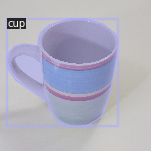

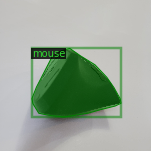

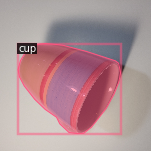

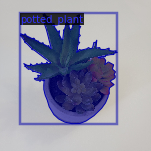

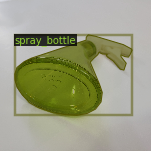

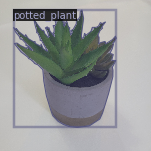

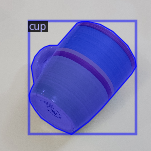

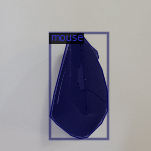

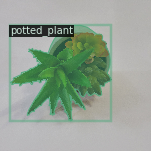

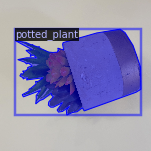

In [ ]:
import random
from detectron2.utils.visualizer import Visualizer
import cv2

from detectron2.data import DatasetCatalog, MetadataCatalog
dataset_dicts = DatasetCatalog.get("prix_train")
prix_metadata = MetadataCatalog.get("prix_train")

for d in random.sample(dataset_dicts, 10):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=prix_metadata, scale=0.05)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

# Trainnig

## Setting up trainnig

Creating a hook to compute our validation loss every few iterations

In [ ]:
from detectron2.engine.hooks import HookBase
from detectron2.evaluation import inference_context
from detectron2.utils.logger import log_every_n_seconds
from detectron2.data import DatasetMapper, build_detection_test_loader
import detectron2.utils.comm as comm
import logging
import torch
import time
import datetime


class LossEvalHook(HookBase):
    def __init__(self, eval_period, model, data_loader):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader
    
    def _do_loss_eval(self):
        # Copying inference_on_dataset from evaluator.py
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)
            
        start_time = time.perf_counter()
        total_compute_time = 0
        losses = []
        for idx, inputs in enumerate(self._data_loader):            

            if idx == num_warmup:
                start_time = time.perf_counter()
                total_compute_time = 0
            start_compute_time = time.perf_counter()

            if torch.cuda.is_available():
                torch.cuda.synchronize()

            total_compute_time += time.perf_counter() - start_compute_time
            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            seconds_per_img = total_compute_time / iters_after_start

            if idx >= num_warmup * 2 or seconds_per_img > 5:

                total_seconds_per_img = (time.perf_counter() - start_time) / iters_after_start
                eta = datetime.timedelta(seconds=int(total_seconds_per_img * (total - idx - 1)))
                log_every_n_seconds(
                    logging.INFO,
                    "Loss on Validation  done {}/{}. {:.4f} s / img. ETA={}".format(
                        idx + 1, total, seconds_per_img, str(eta)
                    ),
                    n=5,
                )
                
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)
        
        mean_loss = np.mean(losses)
        self.trainer.storage.put_scalar('validation_loss', mean_loss)
        comm.synchronize()

        return losses


    def _get_loss(self, data):
        # How loss is calculated on train_loop 
        metrics_dict = self._model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }
        total_losses_reduced = sum(loss for loss in metrics_dict.values())
        return total_losses_reduced


    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            self._do_loss_eval()
        self.trainer.storage.put_scalars(timetest=12)


from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator


class MyTrainer(DefaultTrainer):
    
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)
                     
    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(-1, LossEvalHook(
            cfg.TEST.EVAL_PERIOD,
            self.model,
            build_detection_test_loader(
                self.cfg,
                self.cfg.DATASETS.TEST[0],
                DatasetMapper(self.cfg,True)
            )
        ))
        return hooks        

## Performing training

In [ ]:
import os
import numpy as np
from detectron2.structures import BoxMode
from detectron2.config import get_cfg


selectedModel = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"

cfg = get_cfg()
preTrainedModel = selectedModel
cfg.merge_from_file(model_zoo.get_config_file(preTrainedModel))

# training
cfg.DATASETS.TRAIN = ("prix_train",)

# validation
cfg.DATASETS.TEST = ("prix_val", )
cfg.TEST.EVAL_PERIOD = 500
cfg.DATALOADER.NUM_WORKERS = 4
 
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(preTrainedModel)
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64   # (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 10
 
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001      # 0.00025  # learning rate
cfg.SOLVER.MAX_ITER = 1400      # adjust up if val mAP is still rising, adjust down if overfit
 
cfg.SOLVER.STEPS = (1000, 1500) # tuple (300, 400)
cfg.SOLVER.GAMMA = 0.05         #[0.1]
cfg.SOLVER.WARMUP_ITERS = 1000
 
#cfg.SOLVER.WARMUP_FACTOR = 0.001
#cfg.SOLVER.WARMUP_METHOD = 'linear'


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# trainer = DefaultTrainer(cfg)     # will use the Detectron2 default trainer
trainer = MyTrainer(cfg)            # will use our custom trainer that computes the validation losses too
trainer.resume_or_load(resume=False)
trainer.train()


%load_ext tensorboard
%tensorboard --logdir output


## Saving fine-tuned model

In [ ]:
# Save model on my drive
!cp -r output/ /content/drive/MyDrive/CSE/Spring21/cv2/Task_1/models/midterm_model/



# Evaluation & Inference (using the saved fine-tuned model)

---
## Validation set (only objects)
---

### **Evaluation** using AP metric

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8   # set the testing threshold for this model
cfg.DATASETS.TEST = ("prix_val", )
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("prix_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "prix_val")
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [03/27 02:55:42 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[03/27 02:55:42 d2.data.datasets.coco]: Loaded 83 images in COCO format from /content/drive/MyDrive/CSE/Spring21/cv2/dataset/prix_objects_v1/val/annotations.json
[03/27 02:55:42 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[03/27 02:55:42 d2.data.common]: Serializing 83 elements to byte tensors and concatenating them all ...
[03/27 02:55:42 d2.data.common]: Serialized dataset takes 0.09 MiB
[03/27 02:55:42 d2.evaluation.evaluator]: Start inference on 83 images
[03/27 02:55:53 d2.evaluation.evaluator]: Inference done 11/83. 0.0824 s / img. ETA=0:01:12
[03/27 02:55:58 d2.evaluation.evaluator]: Inference done 17/83. 0.0810 s / img. ETA=0:01:03
[03/27 02:56:04 d2.evaluation.evaluator]: Inference done 26/83.

OrderedDict([('bbox',
              {'AP': 31.87514430997529,
               'AP-book': 70.15016501650166,
               'AP-control': 13.655936225547253,
               'AP-cup': 40.11771177117712,
               'AP-mouse': 17.382161293052384,
               'AP-orange': 53.67161716171618,
               'AP-painting_brush': 1.998731892893723,
               'AP-potted_plant': 50.8512101210121,
               'AP-smart_plug': 25.931869237343903,
               'AP-spray_bottle': 30.792079207920793,
               'AP-stuffed_dog': 14.19996117258785,
               'AP50': 71.11841334544681,
               'AP75': 23.89721472147215,
               'APl': 31.87514430997529,
               'APm': nan,
               'APs': nan}),
             ('segm',
              {'AP': 33.33594236673882,
               'AP-book': 76.4454375993155,
               'AP-control': 17.276756247053278,
               'AP-cup': 41.166460396039604,
               'AP-mouse': 13.300330033003299,
             

### **Inference**
visualizing the prediction results on samples from the prix validation set

[03/27 02:48:30 d2.data.datasets.coco]: Loaded 83 images in COCO format from /content/drive/MyDrive/CSE/Spring21/cv2/dataset/prix_objects_v1/val/annotations.json


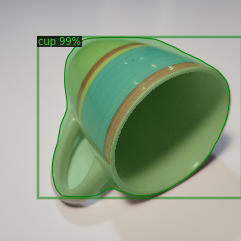

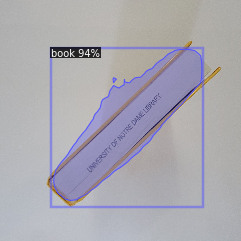

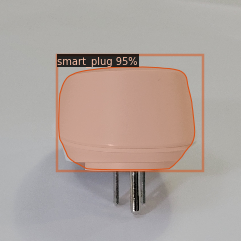

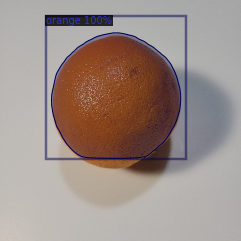

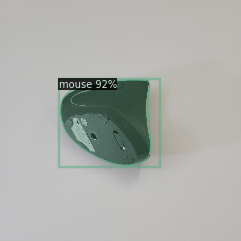

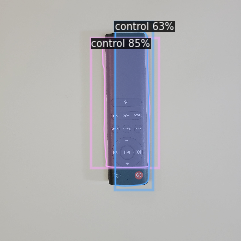

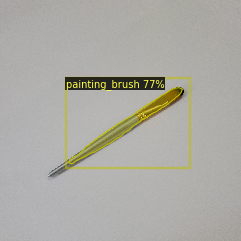

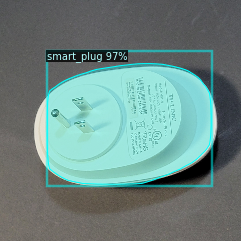

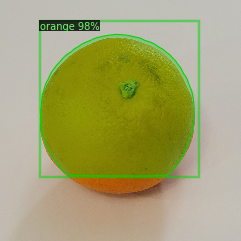

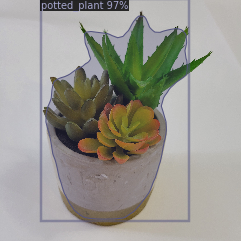

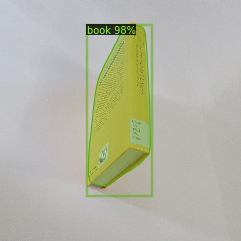

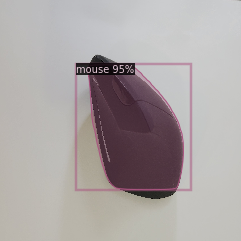

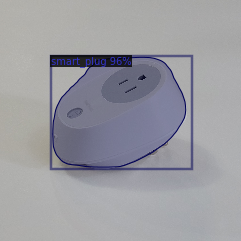

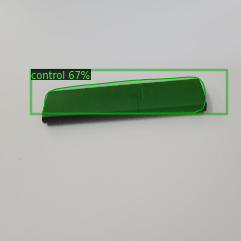

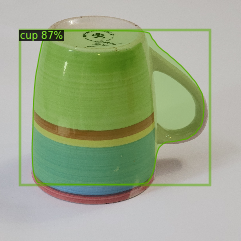

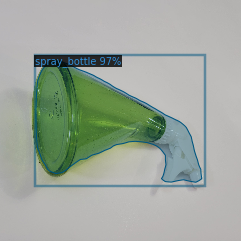

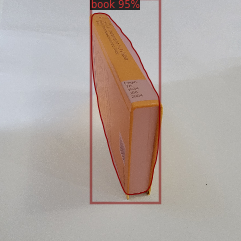

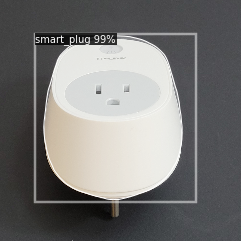

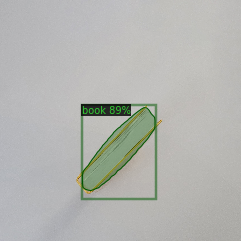

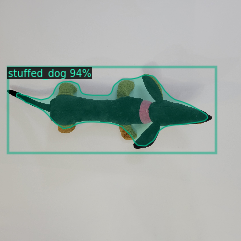

In [ ]:
import numpy as np
def concat_imgs(im1,im2):
  [h,w,d] = im1.shape
  comp_im = np.ndarray(shape=(h,2*w,d), dtype=im1.dtype)
  comp_im[:,:w,:] = im1
  comp_im[:,w:,:] = im2
  return comp_im
  
# Inference
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import Visualizer

dataset_name = "prix_val"
num_samples =5

for d in random.sample(DatasetCatalog.get(dataset_name), num_samples):        
  im = cv2.imread(d["file_name"])
  outputs = predictor(im)
      
  # groundtruth image
  visualizer = Visualizer(im[:, :, ::-1], metadata=MetadataCatalog.get(dataset_name), scale=0.05)
  vis_gt = visualizer.draw_dataset_dict(d)      
  im_gt = vis_gt.get_image()[:, :, ::-1]
 
  # predicted image
  visualizer = Visualizer(im[:, :, ::-1], metadata=tote_metadata, scale=0.05)
  vis_pr = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))            
  im_pr = vis_pr.get_image()[:, :, ::-1]
      
  # show images
  print(dataset_name + ' | ' + d["file_name"].split('/')[-1])
  cv2_imshow(concat_imgs(im_pr, im_gt))

---
## Test set ( Uncluttered Tote Images)
---

### **Inference**
*Visualizing the prediction results on samples from the prix_uncluttered_tote unseen set*

In [ ]:
# Import some common libraries
from os import listdir
from os.path import isfile, join
import random
import re
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

*Register coco instances => Tote images*

In [ ]:
# Register coco instances
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog

path_test_dataset = "/content/drive/MyDrive/CSE/Spring21/cv2/dataset/prix_objects_v1/test/"
list_dataset_name = listdir(path_test_dataset)

for d in list_dataset_name:
  register_coco_instances(d, {}, join(join(path_test_dataset, d),"annotations.json"), join(path_test_dataset, d))



*Load Model*

In [ ]:
# Load Model
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo


path_model = '/content/drive/MyDrive/CSE/Spring21/cv2/Task_1/models/midterm_model/output'
cfg = get_cfg() 
cfg.merge_from_file(model_zoo.get_config_file('COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml'))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2 
cfg.MODEL.WEIGHTS = join(path_model, "model_final.pth")
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 10
predictor = DefaultPredictor(cfg)

*Inference*

In [ ]:
# Inference
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import Visualizer

for dataset_name in list_dataset_name:
  cfg.DATASETS.TEST = (dataset_name, )
  dataset_dicts = DatasetCatalog.get(dataset_name)
  tote_metadata = MetadataCatalog.get(dataset_name)

  print(dataset_name)
  n=5
  for d in random.sample(dataset_dicts, n):        
      im = cv2.imread(d["file_name"])
      outputs = predictor(im)
      
      # groundtruth image
      visualizer = Visualizer(im[:, :, ::-1], metadata=tote_metadata, scale=0.05)
      vis_gt = visualizer.draw_dataset_dict(d)      
      im_gt = vis_gt.get_image()[:, :, ::-1]
 
      # predicted image
      visualizer = Visualizer(im[:, :, ::-1], metadata=tote_metadata, scale=0.05)
      vis_pr = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))            
      im_pr = vis_pr.get_image()[:, :, ::-1]
      
      # show images
      print(dataset_name + ' | ' + d["file_name"].split('/')[-1])
      cv2_imshow(concat_imgs(im_pr, im_gt))

### **Evaluation** using AP metric

In [ ]:
# Register coco instances
from detectron2.data.datasets import register_coco_instances

prix_dataset_test1 = "/content/drive/MyDrive/CSE/Spring21/cv2/dataset/prix_objects_v1/test/light_ambient_vs"
prix_dataset_test2 = "/content/drive/MyDrive/CSE/Spring21/cv2/dataset/prix_objects_v1/test/light_ambient_vt"
prix_dataset_test3 = "/content/drive/MyDrive/CSE/Spring21/cv2/dataset/prix_objects_v1/test/light_side_vs"
prix_dataset_test4 = "/content/drive/MyDrive/CSE/Spring21/cv2/dataset/prix_objects_v1/test/light_side_vt"
prix_dataset_test5 = "/content/drive/MyDrive/CSE/Spring21/cv2/dataset/prix_objects_v1/test/light_top_vs"
prix_dataset_test6 = "/content/drive/MyDrive/CSE/Spring21/cv2/dataset/prix_objects_v1/test/light_top_vt"

register_coco_instances("prix_test_1", {}, join(prix_dataset_test1,"annotations.json"), prix_dataset_test1)
register_coco_instances("prix_test_2", {}, join(prix_dataset_test2,"annotations.json"), prix_dataset_test2)
register_coco_instances("prix_test_3", {}, join(prix_dataset_test3,"annotations.json"), prix_dataset_test3)
register_coco_instances("prix_test_4", {}, join(prix_dataset_test4,"annotations.json"), prix_dataset_test4)
register_coco_instances("prix_test_5", {}, join(prix_dataset_test5,"annotations.json"), prix_dataset_test5)
register_coco_instances("prix_test_6", {}, join(prix_dataset_test6,"annotations.json"), prix_dataset_test6)


In [ ]:
# Load Model
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2   # set the testing threshold for this model

from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

---
#### **Light**: ambient, **View**: side
---


In [ ]:
name_set = "prix_test_1"
cfg.DATASETS.TEST = (name_set, )

evaluator = COCOEvaluator(name_set, cfg, False, output_dir="./output/"+name_set)
val_loader = build_detection_test_loader(cfg, name_set)
inference_on_dataset(trainer.model, val_loader, evaluator)

#predictor = DefaultPredictor(cfg)

WARNING [03/27 06:58:18 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[03/27 06:58:18 d2.data.datasets.coco]: Loaded 22 images in COCO format from /content/drive/MyDrive/CSE/Spring21/cv2/dataset/prix_objects_v1/test/light_ambient_vs/annotations.json
[03/27 06:58:18 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[03/27 06:58:18 d2.data.common]: Serializing 22 elements to byte tensors and concatenating them all ...
[03/27 06:58:18 d2.data.common]: Serialized dataset takes 0.20 MiB
[03/27 06:58:18 d2.evaluation.evaluator]: Start inference on 22 images
[03/27 07:01:12 d2.evaluation.evaluator]: Inference done 11/22. 0.4619 s / img. ETA=0:03:15
[03/27 07:01:33 d2.evaluation.evaluator]: Inference done 12/22. 0.4723 s / img. ETA=0:03:01
[03/27 07:01:57 d2.evaluation.evaluator]: Inf

OrderedDict([('bbox',
              {'AP': 8.432637713370507,
               'AP-book': 4.720803445551929,
               'AP-control': 10.203762927839538,
               'AP-cup': 4.566167158190472,
               'AP-mouse': 7.780467004744879,
               'AP-orange': 22.584303612946975,
               'AP-painting_brush': 1.1699831431284031,
               'AP-potted_plant': 2.842998585572843,
               'AP-smart_plug': 2.6472354541015997,
               'AP-spray_bottle': 10.483401281304602,
               'AP-stuffed_dog': 17.32725452032383,
               'AP50': 21.25021783960725,
               'AP75': 3.0494685736176526,
               'APl': 8.456667920331675,
               'APm': nan,
               'APs': nan}),
             ('segm',
              {'AP': 12.519035563368183,
               'AP-book': 6.558029218820499,
               'AP-control': 16.58160024305688,
               'AP-cup': 6.47337171931321,
               'AP-mouse': 15.09030595580615,
            


---
#### **Light**: ambient, **View**: top
---


In [ ]:

name_set = "prix_test_2"
cfg.DATASETS.TEST = (name_set, )

evaluator = COCOEvaluator(name_set, cfg, False, output_dir="./output/"+name_set)
val_loader = build_detection_test_loader(cfg, name_set)
inference_on_dataset(trainer.model, val_loader, evaluator)

#predictor = DefaultPredictor(cfg)

WARNING [03/27 06:48:10 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[03/27 06:48:10 d2.data.datasets.coco]: Loaded 15 images in COCO format from /content/drive/MyDrive/CSE/Spring21/cv2/dataset/prix_objects_v1/test/light_ambient_vt/annotations.json
[03/27 06:48:10 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[03/27 06:48:10 d2.data.common]: Serializing 15 elements to byte tensors and concatenating them all ...
[03/27 06:48:10 d2.data.common]: Serialized dataset takes 0.08 MiB
[03/27 06:48:10 d2.evaluation.evaluator]: Start inference on 15 images
[03/27 06:50:03 d2.utils.memory]: Attempting to copy inputs of <function paste_masks_in_image at 0x7f0503ed0b00> to CPU due to CUDA OOM
[03/27 06:51:36 d2.utils.memory]: Attempting to copy inputs of <function paste_masks_in_image

OrderedDict([('bbox',
              {'AP': 25.111916550363677,
               'AP-book': 44.33804899065758,
               'AP-control': 19.825471102729246,
               'AP-cup': 13.681640870450451,
               'AP-mouse': 30.26959344286077,
               'AP-orange': 50.02970681683553,
               'AP-painting_brush': 14.791473632657382,
               'AP-potted_plant': 8.13777974310937,
               'AP-smart_plug': 1.63574174733048,
               'AP-spray_bottle': 37.86421499292786,
               'AP-stuffed_dog': 30.545494164078068,
               'AP50': 52.861769612762885,
               'AP75': 17.30778235768007,
               'APl': 25.111916550363677,
               'APm': nan,
               'APs': nan}),
             ('segm',
              {'AP': 31.186083199761455,
               'AP-book': 56.72888946789415,
               'AP-control': 31.415962994131164,
               'AP-cup': 25.116327777679377,
               'AP-mouse': 53.75628019060418,
          

--- 
#### **Light**: side , **View**: side
---

In [ ]:
name_set = "prix_test_3"
cfg.DATASETS.TEST = (name_set, )

evaluator = COCOEvaluator(name_set, cfg, False, output_dir="./output/"+name_set)
val_loader = build_detection_test_loader(cfg, name_set)
inference_on_dataset(trainer.model, val_loader, evaluator)

#predictor = DefaultPredictor(cfg)

WARNING [03/27 06:39:19 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[03/27 06:39:19 d2.data.datasets.coco]: Loaded 21 images in COCO format from /content/drive/MyDrive/CSE/Spring21/cv2/dataset/prix_objects_v1/test/light_side_vs/annotations.json
[03/27 06:39:19 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[03/27 06:39:19 d2.data.common]: Serializing 21 elements to byte tensors and concatenating them all ...
[03/27 06:39:19 d2.data.common]: Serialized dataset takes 0.12 MiB
[03/27 06:39:19 d2.evaluation.evaluator]: Start inference on 21 images
[03/27 06:43:26 d2.evaluation.evaluator]: Inference done 11/21. 0.5169 s / img. ETA=0:03:39
[03/27 06:43:57 d2.evaluation.evaluator]: Inference done 12/21. 0.5395 s / img. ETA=0:03:29
[03/27 06:44:37 d2.evaluation.evaluator]: Infere

OrderedDict([('bbox',
              {'AP': 16.816541973902673,
               'AP-book': 9.77131367554662,
               'AP-control': 19.96807602889396,
               'AP-cup': 15.235590926933144,
               'AP-mouse': 21.80861981546992,
               'AP-orange': 33.7552831663473,
               'AP-painting_brush': 7.089473811139474,
               'AP-potted_plant': 18.55191256830601,
               'AP-smart_plug': 0.6010820862306012,
               'AP-spray_bottle': 10.786249780440228,
               'AP-stuffed_dog': 30.597817879719447,
               'AP50': 35.277788544191466,
               'AP75': 11.195257045263588,
               'APl': 16.8278176434619,
               'APm': nan,
               'APs': nan}),
             ('segm',
              {'AP': 20.807572834395547,
               'AP-book': 14.650691092474153,
               'AP-control': 31.60408383478364,
               'AP-cup': 21.213642757023386,
               'AP-mouse': 37.293347894907704,
          

---
#### **Light**: side, **View**: top
---

In [ ]:
name_set = "prix_test_4"
cfg.DATASETS.TEST = (name_set, )

evaluator = COCOEvaluator(name_set, cfg, False, output_dir="./output/"+name_set)
val_loader = build_detection_test_loader(cfg, name_set)
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [03/27 06:29:44 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[03/27 06:29:44 d2.data.datasets.coco]: Loaded 15 images in COCO format from /content/drive/MyDrive/CSE/Spring21/cv2/dataset/prix_objects_v1/test/light_side_vt/annotations.json
[03/27 06:29:44 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[03/27 06:29:44 d2.data.common]: Serializing 15 elements to byte tensors and concatenating them all ...
[03/27 06:29:44 d2.data.common]: Serialized dataset takes 0.08 MiB
[03/27 06:29:44 d2.evaluation.evaluator]: Start inference on 15 images
[03/27 06:30:38 d2.utils.memory]: Attempting to copy inputs of <function paste_masks_in_image at 0x7f0503ed0b00> to CPU due to CUDA OOM
[03/27 06:31:36 d2.evaluation.evaluator]: Inference done 2/15. 6.5084 s / img. ETA=0:12:13
[03/2

OrderedDict([('bbox',
              {'AP': 19.4144762724504,
               'AP-book': 46.69350053472247,
               'AP-control': 12.477033028237226,
               'AP-cup': 10.892645758831412,
               'AP-mouse': 20.90638191726149,
               'AP-orange': 35.040917871428555,
               'AP-painting_brush': 5.640952158740465,
               'AP-potted_plant': 10.190557658707046,
               'AP-smart_plug': 2.417605449476068,
               'AP-spray_bottle': 10.009416065988857,
               'AP-stuffed_dog': 39.875752281110465,
               'AP50': 45.58534915959081,
               'AP75': 9.468092945819539,
               'APl': 19.4144762724504,
               'APm': nan,
               'APs': nan}),
             ('segm',
              {'AP': 28.202470283778226,
               'AP-book': 66.16921920475119,
               'AP-control': 21.44044952102923,
               'AP-cup': 36.5329223939868,
               'AP-mouse': 40.67276843963466,
              

---
#### **Light**: top, **View**: side
---



In [ ]:
name_set = "prix_test_5"
cfg.DATASETS.TEST = (name_set, )

evaluator = COCOEvaluator(name_set, cfg, False, output_dir="./output/"+name_set)
val_loader = build_detection_test_loader(cfg, name_set)
inference_on_dataset(trainer.model, val_loader, evaluator)

#predictor = DefaultPredictor(cfg)

WARNING [03/27 06:14:21 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[03/27 06:14:21 d2.data.datasets.coco]: Loaded 26 images in COCO format from /content/drive/MyDrive/CSE/Spring21/cv2/dataset/prix_objects_v1/test/light_top_vs/annotations.json
[03/27 06:14:21 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[03/27 06:14:21 d2.data.common]: Serializing 26 elements to byte tensors and concatenating them all ...
[03/27 06:14:21 d2.data.common]: Serialized dataset takes 0.16 MiB
[03/27 06:14:21 d2.evaluation.evaluator]: Start inference on 26 images
[03/27 06:17:09 d2.utils.memory]: Attempting to copy inputs of <function paste_masks_in_image at 0x7f0503ed0b00> to CPU due to CUDA OOM
[03/27 06:20:33 d2.evaluation.evaluator]: Inference done 11/26. 0.5825 s / img. ETA=0:05:56
[03/2

OrderedDict([('bbox',
              {'AP': 14.697376902402981,
               'AP-book': 18.744789190738416,
               'AP-control': 1.3899865227802308,
               'AP-cup': 4.960183829118228,
               'AP-mouse': 2.8082133469079116,
               'AP-orange': 40.651933626243505,
               'AP-painting_brush': 9.170980195672419,
               'AP-potted_plant': 9.8396357681321,
               'AP-smart_plug': 0.009429514380009428,
               'AP-spray_bottle': 20.99716685653753,
               'AP-stuffed_dog': 38.40145017351947,
               'AP50': 31.69363835430274,
               'AP75': 10.006406582418064,
               'APl': 14.697376902402981,
               'APm': nan,
               'APs': nan}),
             ('segm',
              {'AP': 17.187771767471716,
               'AP-book': 10.242070442553,
               'AP-control': 2.385735582066633,
               'AP-cup': 8.19681128252419,
               'AP-mouse': 4.985958544736958,
            

---
#### **Light**: top, **View**: top
---

In [ ]:
name_set = "prix_test_6"
cfg.DATASETS.TEST = (name_set, )

evaluator = COCOEvaluator(name_set, cfg, False, output_dir="./output/"+name_set)
val_loader = build_detection_test_loader(cfg, name_set)
inference_on_dataset(trainer.model, val_loader, evaluator)

# predictor = DefaultPredictor(cfg)

WARNING [03/27 05:13:16 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[03/27 05:13:17 d2.data.datasets.coco]: Loaded 10 images in COCO format from /content/drive/MyDrive/CSE/Spring21/cv2/dataset/prix_objects_v1/test/light_top_vt/annotations.json
[03/27 05:13:17 d2.data.build]: Distribution of instances among all 10 categories:
|   category   | #instances   |  category  | #instances   |   category    | #instances   |
|:------------:|:-------------|:----------:|:-------------|:-------------:|:-------------|
|    orange    | 10           |    cup     | 10           | potted_plant  | 10           |
|    mouse     | 10           |  control   | 10           | painting_br.. | 10           |
|  smart_plug  | 10           |    book    | 10           |  stuffed_dog  | 10           |
| spray_bottle | 10           |            |              |               |              |
|    total     | 100     

OrderedDict([('bbox',
              {'AP': 15.977332373252159,
               'AP-book': 49.59735973597359,
               'AP-control': 2.0852585910906813,
               'AP-cup': 10.618811881188119,
               'AP-mouse': 16.13861386138614,
               'AP-orange': 22.166163424853124,
               'AP-painting_brush': 4.257425742574258,
               'AP-potted_plant': 7.739273927392739,
               'AP-smart_plug': 0.22439313853693915,
               'AP-spray_bottle': 12.674813699857381,
               'AP-stuffed_dog': 34.27120972966862,
               'AP50': 30.89164702738515,
               'AP75': 15.157820491543013,
               'APl': 15.977332373252159,
               'APm': nan,
               'APs': nan}),
             ('segm',
              {'AP': 16.955318236314444,
               'AP-book': 48.026402640264024,
               'AP-control': 3.1507818769952323,
               'AP-cup': 10.185643564356434,
               'AP-mouse': 25.643564356435643,
    

 ### Saving results 

In [ ]:
# Save all results
!cp -r output/ /content/drive/MyDrive/CSE/Spring21/cv2/Task_1/models/midterm_model/